##Titanic kaggle competition

Notes on predicting survivals on titanic with the data from corresponding kaggle competition.

First, we read the training data and have a look at it

In [14]:
import pandas as pd
titanic=pd.read_csv('train.csv')
print(titanic.head())
print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
       P

Column `age` has missing values. We don't want to omit this data so we fill it with the median of existing ages.

In [15]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

We'll ignore `Ticket`, `Cabin` and `Name` columns. Ticket number and name don't tell much whether a person is going to survive and there is to many missing values in `Cabin` column

To deal with `Sex` we'll replace "male" with 0 and "female" with 1.

In [16]:
#check for unique values in the column
print(titanic["Sex"].unique())

['male' 'female']


In [17]:
titanic.loc[titanic["Sex"] == "male", "Sex"]=0
titanic.loc[titanic["Sex"] == "female", "Sex"]=1

Now to the `Embarked` column. We'll assign to the missing values the most popular value 'S' and replace all values with numbers starting from 0.

In [18]:
print(titanic["Embarked"].unique())

['S' 'C' 'Q' nan]


In [26]:
titanic["Embarked"]=titanic["Embarked"].fillna('S')
print(titanic["Embarked"].unique())

['S' 'C' 'Q']


In [28]:
titanic.loc[titanic["Embarked"] == 'S', "Embarked"] = 0
titanic.loc[titanic["Embarked"] == 'C', "Embarked"] = 1
titanic.loc[titanic["Embarked"] == 'Q', "Embarked"] = 2

Predict with linear regression using cross-validation

In [47]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

In [48]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = (predictions==titanic["Survived"]).mean()

0.78338945005611671

Now to the logistic regression

In [58]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.787878787879


Now to the processing of test data

In [57]:
titanic_test=pd.read_csv('test.csv')
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"]=0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"]=1
titanic_test["Embarked"]=titanic_test["Embarked"].fillna('S')
titanic_test.loc[titanic_test["Embarked"] == 'S', "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == 'C', "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == 'Q', "Embarked"] = 2
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic["Fare"].median())

In [61]:
alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle.csv", index=False)

Now we'll do the prediction using random forests

In [63]:
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.800224466891


Let's tweak some parameters

In [64]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.819304152637


In [65]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

Extract titles from the name

In [67]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Mme           1
Don           1
Jonkheer      1
Ms            1
Capt          1
Sir           1
Countess      1
Lady          1
dtype: int64


In [69]:
# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
dtype: int64


In [70]:
# Add in the title column.
titanic["Title"] = titles

In [72]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


Let's do selection of best values

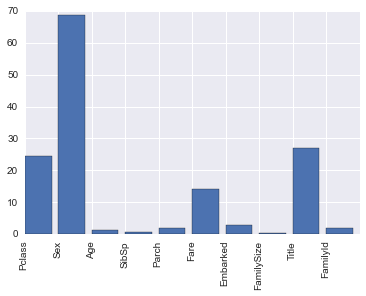

0.811447811448


In [77]:
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


/home/egor/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:37: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [80]:
#process test data

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
dtype: int64


In [81]:
#predicting on test data

predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
predictions=predictions.astype(int)
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_gbc+logreg.csv", index=False)

This submission gives 0.79904 precision.